# TabM精简版：性早熟预测模型

**使用精简特征集（9个特征）进行模型训练**

精简特征基于医生临床经验筛选：
- LH/FSH 相关：基础LH、基础FSH、LH/FSH比值
- 骨龄相关：骨龄、骨龄与实际年龄比值、生物年龄和骨龄之间的差异
- 子宫卵巢径线/体积：子宫长宽厚体积、左右卵巢长宽厚体积、卵巢平均值

本笔记本流程与 Tabm_Enhanced.ipynb 一致

## 1. 导入必要的库

In [1]:
import os
import math
import random
from copy import deepcopy

import pandas as pd
import numpy as np
import warnings
import joblib

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

import tabm
import rtdl_num_embeddings
import torch
import torch.nn as nn
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

print(f"TabM版本: {tabm.__version__ if hasattr(tabm, '__version__') else 'N/A'}")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU设备: {torch.cuda.get_device_name(0)}")
print("所有库导入完成")

TabM版本: 0.0.3
PyTorch版本: 2.9.1+cu130
CUDA可用: True
GPU设备: NVIDIA GeForce RTX 3080 Laptop GPU
所有库导入完成


## 2. 设置路径和参数

In [2]:
os.makedirs("./output", exist_ok=True)
os.makedirs("../output/tabm_simplified", exist_ok=True)
os.makedirs("../output/tabm_simplified/models", exist_ok=True)

RANDOM_SEED = 825
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"随机种子设置: {RANDOM_SEED}")
print(f"计算设备: {DEVICE}")
print(f"输出目录: ../output/tabm_simplified/")

随机种子设置: 825
计算设备: cuda
输出目录: ../output/tabm_simplified/


## 3. 读取精简特征数据

In [3]:
normal_data = pd.read_csv("../input/性早熟数据激发试验正常组_simplified.csv")
disease_data = pd.read_csv("../input/激发试验确诊性早熟组数据_simplified.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, {normal_data.shape[1]} 列")
print(f"早熟组: {disease_data.shape[0]} 行, {disease_data.shape[1]} 列")
print(f"\n精简特征列表:")
for col in normal_data.columns:
    if col not in ["group", "患者编号"]:
        print(f"  - {col}")

正常组: 299 行, 8 列
早熟组: 364 行, 8 列

精简特征列表:
  - 基础血清促黄体生成激素（LH）
  - 子宫长（cm）
  - 子宫厚（cm）
  - 最大卵泡直径直径
  - 卵巢体积平均值
  - LH/FSH比值


## 4. 数据合并与划分

In [4]:
# 分组填补：先对每组分别填补，再合并
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in normal_data.columns if col not in exclude_cols]

print(f"使用 {len(feature_cols)} 个精简特征")
print("使用MissForest方法进行分组填补...")

# 分别对正常组和性早熟组进行填补
imputer_normal = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)
imputer_disease = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)

normal_features = normal_data[feature_cols].copy()
disease_features = disease_data[feature_cols].copy()

normal_imputed = pd.DataFrame(
    imputer_normal.fit_transform(normal_features), columns=feature_cols
)
disease_imputed = pd.DataFrame(
    imputer_disease.fit_transform(disease_features), columns=feature_cols
)

print(f"正常组填补完成: {normal_imputed.shape}")
print(f"性早熟组填补完成: {disease_imputed.shape}")

# 添加标签列
normal_imputed["group"] = "N"
disease_imputed["group"] = "Y"

# 合并数据
data = pd.concat([normal_imputed, disease_imputed], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"\n合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")
print(f"分组统计:\n{data['group'].value_counts()}")

# 划分训练集和验证集
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)
print(f"\n训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

使用 6 个精简特征
使用MissForest方法进行分组填补...
正常组填补完成: (299, 6)
性早熟组填补完成: (364, 6)

合并后数据: 663 行 x 7 列
分组统计:
group
Y    364
N    299
Name: count, dtype: int64

训练集: 464 行, 验证集: 199 行


## 5. 特征工程与预处理

In [5]:
X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

# 数据已在分组填补阶段完成，直接使用
X_train_num = X_train.values
X_validation_num = X_validation.values

# 标准化
scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_num)
X_validation_processed = scaler.transform(X_validation_num)
print("数值特征已标准化")

feature_cols_processed = feature_cols
print(f"\n预处理完成！特征数: {X_train_processed.shape[1]}")

训练集正负样本: {1: 255, 0: 209}
验证集正负样本: {1: 109, 0: 90}
数值特征已标准化

预处理完成！特征数: 6


## 6. 数据转换为PyTorch张量

In [6]:
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.long).to(DEVICE)
X_val_tensor = torch.tensor(X_validation_processed, dtype=torch.float32).to(DEVICE)
y_val_tensor = torch.tensor(y_validation_binary.values, dtype=torch.long).to(DEVICE)

print(f"训练集张量: {X_train_tensor.shape}")
print(f"验证集张量: {X_val_tensor.shape}")

训练集张量: torch.Size([464, 6])
验证集张量: torch.Size([199, 6])


## 7. 定义训练和评估函数

In [7]:
def train_tabm_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    n_epochs=500,
    batch_size=256,
    lr=2e-3,
    weight_decay=3e-4,
    patience=32,
    gradient_clipping_norm=1.0,
    share_training_batches=True,
    verbose=True,
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    amp_enabled = torch.cuda.is_available()

    best_f1, best_auc, best_epoch, best_state = 0, 0, 0, None
    remaining_patience = patience

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        if share_training_batches:
            batches = torch.randperm(len(X_train), device=DEVICE).split(batch_size)
        else:
            batches = (
                torch.rand((len(X_train), model.backbone.k), device=DEVICE)
                .argsort(dim=0)
                .split(batch_size, dim=0)
            )

        for batch_idx in batches:
            optimizer.zero_grad()
            with torch.autocast(
                device_type="cuda", enabled=amp_enabled, dtype=amp_dtype
            ):
                logits = model(X_train[batch_idx], None)
                y_pred = logits.flatten(0, 1)
                if share_training_batches:
                    y_true = y_train[batch_idx].repeat_interleave(model.backbone.k)
                else:
                    y_true = y_train[batch_idx].flatten(0, 1)
                loss = nn.functional.cross_entropy(y_pred, y_true)
            loss.backward()
            if gradient_clipping_norm:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), gradient_clipping_norm
                )
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val, None)
            val_proba = (
                torch.softmax(val_logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
            )
            val_pred = (val_proba >= 0.5).astype(int)
            y_val_np = y_val.cpu().numpy()
            auc = roc_auc_score(y_val_np, val_proba)
            f1 = f1_score(y_val_np, val_pred)

        improved = f1 > best_f1
        if verbose and (epoch % 50 == 0 or improved):
            print(
                f"Epoch {epoch:3d}: Loss={total_loss/len(batches):.4f}, F1={f1:.4f}, AUC={auc:.4f}{' *' if improved else ''}"
            )
        if improved:
            best_f1, best_auc, best_epoch = f1, auc, epoch
            best_state = deepcopy(model.state_dict())
            remaining_patience = patience
        else:
            remaining_patience -= 1
        if remaining_patience < 0:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

    if best_state:
        model.load_state_dict(best_state)
    return {"best_f1": best_f1, "best_auc": best_auc, "best_epoch": best_epoch}


def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X, None)
        proba = torch.softmax(logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
        pred = (proba >= 0.5).astype(int)
        y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else y
        return {
            "auc": roc_auc_score(y_np, proba),
            "f1": f1_score(y_np, pred),
            "accuracy": accuracy_score(y_np, pred),
            "y_pred": pred,
            "y_proba": proba,
        }


print("训练和评估函数定义完成！")

训练和评估函数定义完成！


## 8. 模型1：基础TabM

In [26]:
print("=" * 70)
print("训练基础TabM模型（精简特征）- 强化正则化防止过拟合")
print("=" * 70)

num_embeddings_basic = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
tabm_basic = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_basic,
    dropout=0.25,
).to(DEVICE)

print(f"模型参数量: {sum(p.numel() for p in tabm_basic.parameters()):,}")
print(f"特征数: {X_train_tensor.shape[1]}")
print(f"正则化: dropout=0.25, weight_decay=2e-3")

result_basic = train_tabm_model(
    tabm_basic,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=300,
    patience=30,
    weight_decay=2e-3,
    lr=1e-3,
)
metrics_basic = evaluate_model(tabm_basic, X_val_tensor, y_val_tensor)

train_metrics_basic = evaluate_model(tabm_basic, X_train_tensor, y_train_tensor)
print(f"\n基础TabM训练集: AUC={train_metrics_basic['auc']:.4f}")
print(
    f"基础TabM验证集: AUC={metrics_basic['auc']:.4f}, F1={metrics_basic['f1']:.4f}, ACC={metrics_basic['accuracy']:.4f}"
)

torch.save(tabm_basic.state_dict(), "../output/tabm_simplified/models/tabm_basic.pt")
joblib.dump(
    {
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
        "scaler": scaler,
    },
    "../output/tabm_simplified/models/tabm_basic_preprocessors.pkl",
)

训练基础TabM模型（精简特征）- 强化正则化防止过拟合
模型参数量: 433,920
特征数: 6
正则化: dropout=0.25, weight_decay=2e-3
Epoch   0: Loss=0.6875, F1=0.7243, AUC=0.8166 *
Epoch   2: Loss=0.6366, F1=0.7340, AUC=0.8062 *
Epoch   3: Loss=0.6024, F1=0.7556, AUC=0.8182 *
Epoch   4: Loss=0.5705, F1=0.7932, AUC=0.8311 *
Epoch   5: Loss=0.5322, F1=0.8091, AUC=0.8493 *
Epoch   6: Loss=0.5060, F1=0.8128, AUC=0.8595 *
Epoch   7: Loss=0.4874, F1=0.8356, AUC=0.8617 *
Epoch  10: Loss=0.4302, F1=0.8412, AUC=0.8686 *
Epoch  11: Loss=0.4152, F1=0.8462, AUC=0.8689 *
Epoch  12: Loss=0.4038, F1=0.8498, AUC=0.8703 *
Epoch  15: Loss=0.3699, F1=0.8559, AUC=0.8722 *
Epoch  16: Loss=0.3660, F1=0.8596, AUC=0.8732 *
Epoch  17: Loss=0.3589, F1=0.8670, AUC=0.8761 *
Epoch  21: Loss=0.3200, F1=0.8718, AUC=0.8826 *
Epoch  41: Loss=0.2187, F1=0.8745, AUC=0.9127 *
Epoch  43: Loss=0.2121, F1=0.8793, AUC=0.9140 *
Epoch  50: Loss=0.1904, F1=0.8745, AUC=0.9205
Epoch  60: Loss=0.1689, F1=0.8821, AUC=0.9306 *
Epoch  81: Loss=0.1194, F1=0.8850, AUC=0.9375 *
Ep

['../output/tabm_simplified/models/tabm_basic_preprocessors.pkl']

## 9. 模型2：TabM-Mini架构

In [27]:
print("=" * 70)
print("训练TabM-Mini架构（精简特征）- 增强正则化")
print("=" * 70)

num_embeddings_mini = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
# 增加dropout正则化
tabm_mini = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_mini,
    arch_type="tabm-mini",
    dropout=0.1,  # 添加10% dropout
).to(DEVICE)

print(f"正则化: dropout=0.1, weight_decay=5e-4")

# 增强正则化参数
result_mini = train_tabm_model(
    tabm_mini,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=500,
    patience=50,  # 减少patience
    weight_decay=5e-4,  # 增加weight decay
)
metrics_mini = evaluate_model(tabm_mini, X_val_tensor, y_val_tensor)

print(
    f"\nTabM-Mini性能: AUC={metrics_mini['auc']:.4f}, F1={metrics_mini['f1']:.4f}, ACC={metrics_mini['accuracy']:.4f}"
)
torch.save(tabm_mini.state_dict(), "../output/tabm_simplified/models/tabm_mini.pt")

训练TabM-Mini架构（精简特征）- 增强正则化
正则化: dropout=0.1, weight_decay=5e-4
Epoch   0: Loss=0.6847, F1=0.7267, AUC=0.8218 *
Epoch   1: Loss=0.6417, F1=0.7315, AUC=0.8220 *
Epoch   2: Loss=0.5941, F1=0.8017, AUC=0.8445 *
Epoch   3: Loss=0.5296, F1=0.8073, AUC=0.8644 *
Epoch   4: Loss=0.4878, F1=0.8225, AUC=0.8630 *
Epoch   5: Loss=0.4590, F1=0.8354, AUC=0.8680 *
Epoch   7: Loss=0.4050, F1=0.8534, AUC=0.8746 *
Epoch   9: Loss=0.3696, F1=0.8596, AUC=0.8817 *
Epoch  11: Loss=0.3324, F1=0.8646, AUC=0.8864 *
Epoch  12: Loss=0.3248, F1=0.8696, AUC=0.8886 *
Epoch  14: Loss=0.2962, F1=0.8831, AUC=0.8897 *
Epoch  30: Loss=0.1902, F1=0.8879, AUC=0.9202 *
Epoch  36: Loss=0.1647, F1=0.8918, AUC=0.9254 *
Epoch  50: Loss=0.1129, F1=0.8821, AUC=0.9318
Early stopping at epoch 87

TabM-Mini性能: AUC=0.9254, F1=0.8918, ACC=0.8744


## 10. 模型3：独立批次训练

In [28]:
print("=" * 70)
print("训练TabM（独立批次策略）- 增强正则化")
print("=" * 70)

num_embeddings_indep = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
# 增加dropout正则化
tabm_indep = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_indep,
    dropout=0.1,  # 添加10% dropout
).to(DEVICE)

print(f"正则化: dropout=0.1, weight_decay=5e-4")

# 增强正则化参数
result_indep = train_tabm_model(
    tabm_indep,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=500,
    patience=50,  # 减少patience
    share_training_batches=False,
    weight_decay=5e-4,  # 增加weight decay
)
metrics_indep = evaluate_model(tabm_indep, X_val_tensor, y_val_tensor)

print(
    f"\nTabM独立批次性能: AUC={metrics_indep['auc']:.4f}, F1={metrics_indep['f1']:.4f}, ACC={metrics_indep['accuracy']:.4f}"
)
torch.save(tabm_indep.state_dict(), "../output/tabm_simplified/models/tabm_indep.pt")

训练TabM（独立批次策略）- 增强正则化
正则化: dropout=0.1, weight_decay=5e-4
Epoch   0: Loss=0.6849, F1=0.7101, AUC=0.8528 *
Epoch   1: Loss=0.6391, F1=0.7483, AUC=0.8524 *
Epoch   2: Loss=0.5754, F1=0.8285, AUC=0.8726 *
Epoch   4: Loss=0.4530, F1=0.8340, AUC=0.8761 *
Epoch   6: Loss=0.3998, F1=0.8376, AUC=0.8817 *
Epoch   7: Loss=0.3817, F1=0.8435, AUC=0.8815 *
Epoch   8: Loss=0.3671, F1=0.8596, AUC=0.8829 *
Epoch   9: Loss=0.3457, F1=0.8707, AUC=0.8849 *
Epoch  11: Loss=0.3175, F1=0.8745, AUC=0.8887 *
Epoch  12: Loss=0.3055, F1=0.8793, AUC=0.8896 *
Epoch  18: Loss=0.2408, F1=0.8831, AUC=0.8973 *
Epoch  50: Loss=0.0644, F1=0.8772, AUC=0.9353
Early stopping at epoch 69

TabM独立批次性能: AUC=0.8973, F1=0.8831, ACC=0.8643


## 11. 模型4：PeriodicEmbeddings

In [29]:
print("=" * 70)
print("训练TabM-Periodic（周期性嵌入）- 增强正则化")
print("=" * 70)

# PeriodicEmbeddings使用不同的API
num_embeddings_periodic = rtdl_num_embeddings.PeriodicEmbeddings(
    n_features=X_train_tensor.shape[1],
    d_embedding=16,
    lite=False,
)
# 增加dropout正则化
tabm_periodic = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_periodic,
    dropout=0.1,
).to(DEVICE)

print(f"正则化: dropout=0.1, weight_decay=5e-4")

# 增强正则化参数
result_periodic = train_tabm_model(
    tabm_periodic,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=500,
    patience=50,
    weight_decay=5e-4,
)
metrics_periodic = evaluate_model(tabm_periodic, X_val_tensor, y_val_tensor)

print(
    f"\nTabM-Periodic性能: AUC={metrics_periodic['auc']:.4f}, F1={metrics_periodic['f1']:.4f}, ACC={metrics_periodic['accuracy']:.4f}"
)
torch.save(
    tabm_periodic.state_dict(), "../output/tabm_simplified/models/tabm_periodic.pt"
)

训练TabM-Periodic（周期性嵌入）- 增强正则化
正则化: dropout=0.1, weight_decay=5e-4
Epoch   0: Loss=0.6887, F1=0.7078, AUC=0.7970 *
Epoch   5: Loss=0.6197, F1=0.8293, AUC=0.8691 *
Epoch   8: Loss=0.4621, F1=0.8412, AUC=0.8732 *
Epoch  11: Loss=0.3977, F1=0.8435, AUC=0.8698 *
Epoch  13: Loss=0.3708, F1=0.8534, AUC=0.8717 *
Epoch  15: Loss=0.3460, F1=0.8596, AUC=0.8727 *
Epoch  16: Loss=0.3414, F1=0.8632, AUC=0.8736 *
Epoch  19: Loss=0.3112, F1=0.8670, AUC=0.8781 *
Epoch  23: Loss=0.2885, F1=0.8707, AUC=0.8825 *
Epoch  34: Loss=0.2387, F1=0.8718, AUC=0.9029 *
Epoch  40: Loss=0.2153, F1=0.8755, AUC=0.9153 *
Epoch  42: Loss=0.2091, F1=0.8766, AUC=0.9206 *
Epoch  43: Loss=0.2087, F1=0.8803, AUC=0.9195 *
Epoch  50: Loss=0.1957, F1=0.8841, AUC=0.9271 *
Epoch  54: Loss=0.1800, F1=0.8879, AUC=0.9306 *
Epoch  64: Loss=0.1618, F1=0.8899, AUC=0.9397 *
Epoch  67: Loss=0.1603, F1=0.8987, AUC=0.9432 *
Epoch  71: Loss=0.1532, F1=0.8996, AUC=0.9437 *
Epoch  95: Loss=0.1190, F1=0.9035, AUC=0.9486 *
Epoch 100: Loss=0.1080

## 12. 模型5：超参数优化（Optuna HPO）

In [30]:
print("=" * 70)
print("TabM超参数优化（HPO）- 强化正则化防止过拟合")
print("=" * 70)

import optuna

best_hpo_model_state = None
best_hpo_f1 = 0.0
best_hpo_config = None


def objective(trial):
    global best_hpo_model_state, best_hpo_f1, best_hpo_config
    n_blocks = trial.suggest_int("n_blocks", 1, 3)
    d_block = trial.suggest_int("d_block", 64, 256, step=64)
    n_bins = trial.suggest_int("n_bins", 16, 64, step=16)
    d_embedding = trial.suggest_int("d_embedding", 8, 24, step=4)
    lr = trial.suggest_float("lr", 5e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-3, 5e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.15, 0.4, step=0.05)
    try:
        num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
            rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=n_bins),
            d_embedding=d_embedding,
            activation=False,
            version="B",
        )
        model = tabm.TabM.make(
            n_num_features=X_train_tensor.shape[1],
            cat_cardinalities=[],
            d_out=2,
            num_embeddings=num_embeddings,
            n_blocks=n_blocks,
            d_block=d_block,
            dropout=dropout,
        ).to(DEVICE)
        result = train_tabm_model(
            model,
            X_train_tensor,
            y_train_tensor,
            X_val_tensor,
            y_val_tensor,
            n_epochs=300,
            patience=25,
            lr=lr,
            weight_decay=weight_decay,
            verbose=False,
        )
        f1 = result["best_f1"]
        if f1 > best_hpo_f1:
            best_hpo_f1 = f1
            best_hpo_model_state = deepcopy(model.state_dict())
            best_hpo_config = {
                "n_blocks": n_blocks,
                "d_block": d_block,
                "n_bins": n_bins,
                "d_embedding": d_embedding,
                "dropout": dropout,
                "weight_decay": weight_decay,
            }
        return f1
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


study = optuna.create_study(direction="maximize", study_name="tabm_simplified_hpo")
study.optimize(objective, n_trials=10000, show_progress_bar=True)

print(f"\n最佳参数: {study.best_params}")
print(f"最佳F1: {study.best_value:.4f}")

num_embeddings_hpo = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=best_hpo_config["n_bins"]),
    d_embedding=best_hpo_config["d_embedding"],
    activation=False,
    version="B",
)
tabm_hpo = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_hpo,
    n_blocks=best_hpo_config["n_blocks"],
    d_block=best_hpo_config["d_block"],
    dropout=best_hpo_config["dropout"],
).to(DEVICE)
tabm_hpo.load_state_dict(best_hpo_model_state)

torch.save(tabm_hpo.state_dict(), "../output/tabm_simplified/models/tabm_hpo.pt")
joblib.dump(
    {
        "best_params": study.best_params,
        "best_config": best_hpo_config,
        "scaler": scaler,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
    },
    "../output/tabm_simplified/models/tabm_hpo_config.pkl",
)

metrics_hpo = evaluate_model(tabm_hpo, X_val_tensor, y_val_tensor)
train_metrics_hpo = evaluate_model(tabm_hpo, X_train_tensor, y_train_tensor)
print(f"\nHPO优化TabM训练集: AUC={train_metrics_hpo['auc']:.4f}")
print(
    f"HPO优化TabM验证集: AUC={metrics_hpo['auc']:.4f}, F1={metrics_hpo['f1']:.4f}, ACC={metrics_hpo['accuracy']:.4f}"
)
print(
    f"HPO参数: n_blocks={best_hpo_config['n_blocks']}, d_block={best_hpo_config['d_block']}, dropout={best_hpo_config['dropout']:.2f}, weight_decay={best_hpo_config['weight_decay']:.4f}"
)

[I 2025-12-28 00:33:23,277] A new study created in memory with name: tabm_simplified_hpo


TabM超参数优化（HPO）- 强化正则化防止过拟合


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-12-28 00:33:24,232] Trial 0 finished with value: 0.8927038626609443 and parameters: {'n_blocks': 2, 'd_block': 256, 'n_bins': 48, 'd_embedding': 16, 'lr': 0.002609458327576357, 'weight_decay': 0.0041452639159606265, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.8927038626609443.
[I 2025-12-28 00:33:24,931] Trial 1 finished with value: 0.8398268398268398 and parameters: {'n_blocks': 1, 'd_block': 64, 'n_bins': 16, 'd_embedding': 16, 'lr': 0.0005825420281819682, 'weight_decay': 0.002016123926642245, 'dropout': 0.4}. Best is trial 0 with value: 0.8927038626609443.
[I 2025-12-28 00:33:25,397] Trial 2 finished with value: 0.8841201716738197 and parameters: {'n_blocks': 1, 'd_block': 256, 'n_bins': 48, 'd_embedding': 24, 'lr': 0.002756437445415278, 'weight_decay': 0.0016133667274246689, 'dropout': 0.25}. Best is trial 0 with value: 0.8927038626609443.
[I 2025-12-28 00:33:26,685] Trial 3 finished with value: 0.8917748917748918 and parameters: {'n_blocks': 2, 'd_block'

## *模型导入

In [8]:
# 模型导入
print("=" * 70)
print("加载已保存的模型")
print("=" * 70)

# 重新创建模型架构并加载权重
# 1. 基础TabM
num_embeddings_basic_load = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
tabm_basic = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_basic_load,
).to(DEVICE)
tabm_basic.load_state_dict(
    torch.load(
        "../output/tabm_simplified/models/tabm_basic.pt",
        map_location=DEVICE,
        weights_only=True,
    )
)
tabm_basic.eval()
print("✓ 基础TabM模型加载完成")

# 2. TabM-Mini
num_embeddings_mini_load = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
tabm_mini = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_mini_load,
    arch_type="tabm-mini",
).to(DEVICE)
tabm_mini.load_state_dict(
    torch.load(
        "../output/tabm_simplified/models/tabm_mini.pt",
        map_location=DEVICE,
        weights_only=True,
    )
)
tabm_mini.eval()
print("✓ TabM-Mini模型加载完成")

# 3. 独立批次TabM
num_embeddings_indep_load = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)
tabm_indep = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_indep_load,
).to(DEVICE)
tabm_indep.load_state_dict(
    torch.load(
        "../output/tabm_simplified/models/tabm_indep.pt",
        map_location=DEVICE,
        weights_only=True,
    )
)
tabm_indep.eval()
print("✓ TabM独立批次模型加载完成")

# 4. TabM-Periodic
num_embeddings_periodic_load = rtdl_num_embeddings.PeriodicEmbeddings(
    n_features=X_train_tensor.shape[1],
    d_embedding=16,
    lite=False,
)
tabm_periodic = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_periodic_load,
).to(DEVICE)
tabm_periodic.load_state_dict(
    torch.load(
        "../output/tabm_simplified/models/tabm_periodic.pt",
        map_location=DEVICE,
        weights_only=True,
    )
)
tabm_periodic.eval()
print("✓ TabM-Periodic模型加载完成")

# 5. HPO优化TabM
hpo_config = joblib.load("../output/tabm_simplified/models/tabm_hpo_config.pkl")
best_config = hpo_config["best_config"]
num_embeddings_hpo_load = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=best_config["n_bins"]),
    d_embedding=best_config["d_embedding"],
    activation=False,
    version="B",
)
tabm_hpo = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_hpo_load,
    n_blocks=best_config["n_blocks"],
    d_block=best_config["d_block"],
    dropout=best_config["dropout"],
).to(DEVICE)
tabm_hpo.load_state_dict(
    torch.load(
        "../output/tabm_simplified/models/tabm_hpo.pt",
        map_location=DEVICE,
        weights_only=True,
    )
)
tabm_hpo.eval()
print("✓ HPO优化TabM模型加载完成")
print(
    f"  HPO参数: n_blocks={best_config['n_blocks']}, d_block={best_config['d_block']}, dropout={best_config['dropout']}"
)

# 评估所有模型（验证集）
print("\n评估验证集性能...")
metrics_basic = evaluate_model(tabm_basic, X_val_tensor, y_val_tensor)
metrics_mini = evaluate_model(tabm_mini, X_val_tensor, y_val_tensor)
metrics_indep = evaluate_model(tabm_indep, X_val_tensor, y_val_tensor)
metrics_periodic = evaluate_model(tabm_periodic, X_val_tensor, y_val_tensor)
metrics_hpo = evaluate_model(tabm_hpo, X_val_tensor, y_val_tensor)

print("\n验证集性能:")
print(f"  基础TabM:     AUC={metrics_basic['auc']:.4f}, F1={metrics_basic['f1']:.4f}")
print(f"  TabM-Mini:    AUC={metrics_mini['auc']:.4f}, F1={metrics_mini['f1']:.4f}")
print(f"  TabM独立批次: AUC={metrics_indep['auc']:.4f}, F1={metrics_indep['f1']:.4f}")
print(
    f"  TabM-Periodic: AUC={metrics_periodic['auc']:.4f}, F1={metrics_periodic['f1']:.4f}"
)
print(f"  HPO优化TabM:  AUC={metrics_hpo['auc']:.4f}, F1={metrics_hpo['f1']:.4f}")

# 评估所有模型（训练集）
print("\n评估训练集性能...")
metrics_basic_train = evaluate_model(tabm_basic, X_train_tensor, y_train_tensor)
metrics_mini_train = evaluate_model(tabm_mini, X_train_tensor, y_train_tensor)
metrics_indep_train = evaluate_model(tabm_indep, X_train_tensor, y_train_tensor)
metrics_periodic_train = evaluate_model(tabm_periodic, X_train_tensor, y_train_tensor)
metrics_hpo_train = evaluate_model(tabm_hpo, X_train_tensor, y_train_tensor)

print("\n训练集性能:")
print(
    f"  基础TabM:     AUC={metrics_basic_train['auc']:.4f}, F1={metrics_basic_train['f1']:.4f}"
)
print(
    f"  TabM-Mini:    AUC={metrics_mini_train['auc']:.4f}, F1={metrics_mini_train['f1']:.4f}"
)
print(
    f"  TabM独立批次: AUC={metrics_indep_train['auc']:.4f}, F1={metrics_indep_train['f1']:.4f}"
)
print(
    f"  TabM-Periodic: AUC={metrics_periodic_train['auc']:.4f}, F1={metrics_periodic_train['f1']:.4f}"
)
print(
    f"  HPO优化TabM:  AUC={metrics_hpo_train['auc']:.4f}, F1={metrics_hpo_train['f1']:.4f}"
)

print("\n所有模型评估完成！")

加载已保存的模型
✓ 基础TabM模型加载完成
✓ TabM-Mini模型加载完成
✓ TabM独立批次模型加载完成
✓ TabM-Periodic模型加载完成
✓ HPO优化TabM模型加载完成
  HPO参数: n_blocks=1, d_block=192, dropout=0.2

评估验证集性能...

验证集性能:
  基础TabM:     AUC=0.9375, F1=0.8850
  TabM-Mini:    AUC=0.9254, F1=0.8918
  TabM独立批次: AUC=0.8973, F1=0.8831
  TabM-Periodic: AUC=0.9501, F1=0.9115
  HPO优化TabM:  AUC=0.9261, F1=0.9075

评估训练集性能...

训练集性能:
  基础TabM:     AUC=0.9968, F1=0.9729
  TabM-Mini:    AUC=0.9895, F1=0.9618
  TabM独立批次: AUC=0.9726, F1=0.9403
  TabM-Periodic: AUC=0.9969, F1=0.9805
  HPO优化TabM:  AUC=0.9986, F1=0.9883

所有模型评估完成！


## 13. 评估最佳模型

In [9]:
results = pd.DataFrame(
    {
        "模型": [
            "基础TabM",
            "TabM-Mini",
            "TabM独立批次",
            "TabM-Periodic",
            "HPO优化TabM",
        ],
        "AUC": [
            metrics_basic["auc"],
            metrics_mini["auc"],
            metrics_indep["auc"],
            metrics_periodic["auc"],
            metrics_hpo["auc"],
        ],
        "F1": [
            metrics_basic["f1"],
            metrics_mini["f1"],
            metrics_indep["f1"],
            metrics_periodic["f1"],
            metrics_hpo["f1"],
        ],
        "ACC": [
            metrics_basic["accuracy"],
            metrics_mini["accuracy"],
            metrics_indep["accuracy"],
            metrics_periodic["accuracy"],
            metrics_hpo["accuracy"],
        ],
    }
)
print("TabM精简特征模型性能对比")
print(results.to_string(index=False))
results.to_csv("../output/tabm_simplified/性能对比.csv", index=False)
# TabM精简特征模型性能对比
#            模型      AUC       F1      ACC
#        基础TabM 0.947706 0.908297 0.894472
#     TabM-Mini 0.939653 0.908297 0.894472
#      TabM独立批次 0.943629 0.904348 0.889447
# TabM-Periodic 0.926911 0.898678 0.884422
#     HPO优化TabM 0.943935 0.921053 0.909548

TabM精简特征模型性能对比
           模型      AUC       F1      ACC
       基础TabM 0.937513 0.884956 0.869347
    TabM-Mini 0.925382 0.891775 0.874372
     TabM独立批次 0.897350 0.883117 0.864322
TabM-Periodic 0.950051 0.911504 0.899497
    HPO优化TabM 0.926096 0.907489 0.894472


# 14. ROC曲线

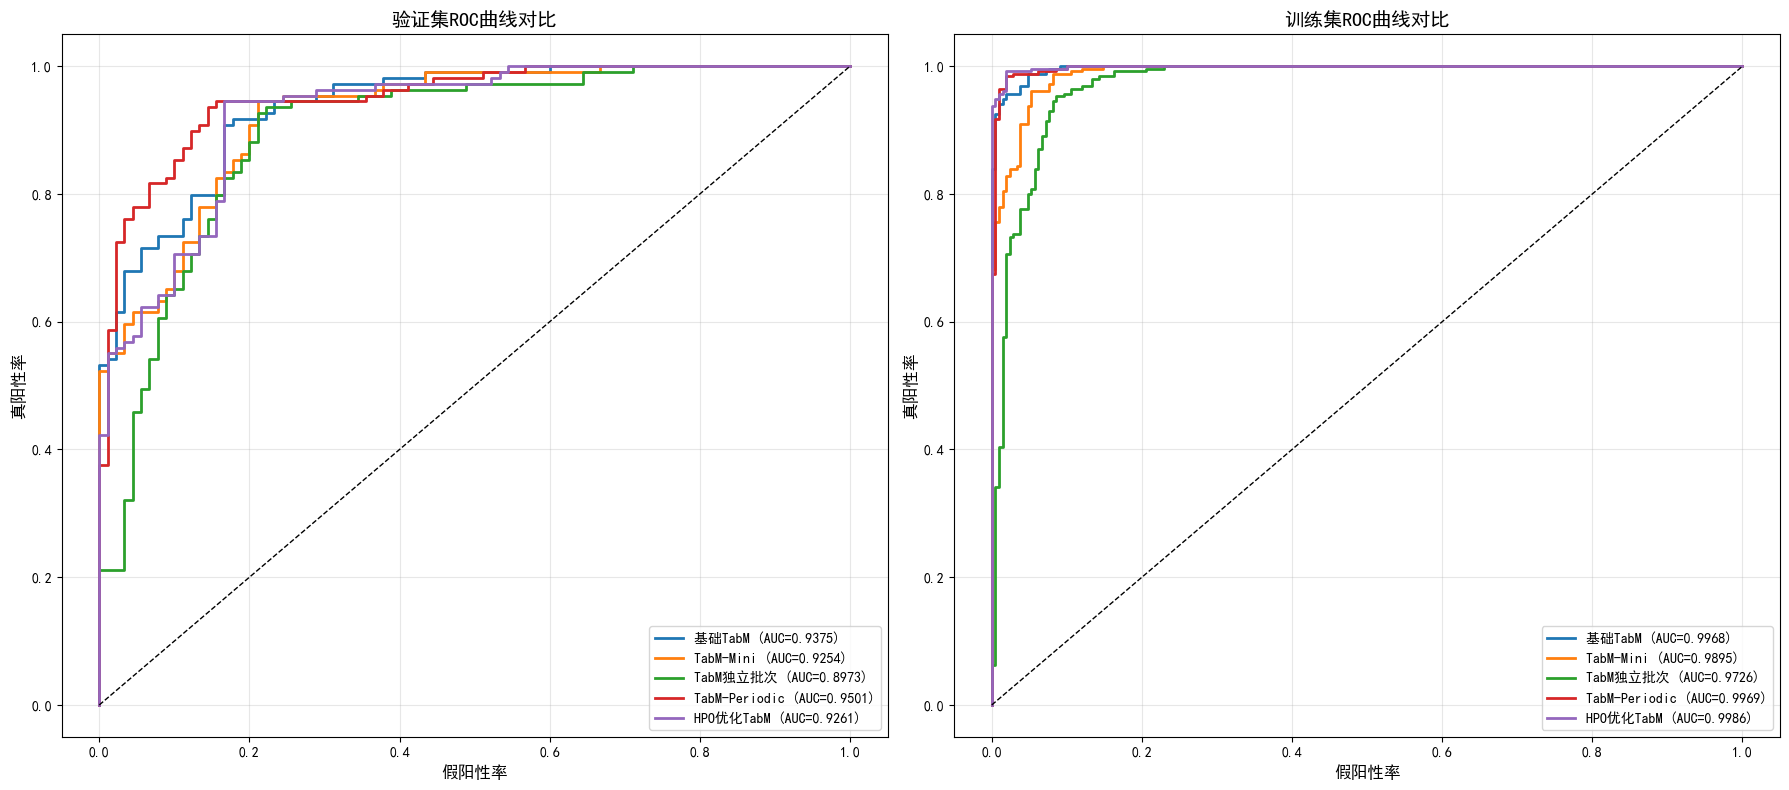

In [10]:
# 计算训练集预测结果
metrics_basic_train = evaluate_model(tabm_basic, X_train_tensor, y_train_tensor)
metrics_mini_train = evaluate_model(tabm_mini, X_train_tensor, y_train_tensor)
metrics_indep_train = evaluate_model(tabm_indep, X_train_tensor, y_train_tensor)
metrics_periodic_train = evaluate_model(tabm_periodic, X_train_tensor, y_train_tensor)
metrics_hpo_train = evaluate_model(tabm_hpo, X_train_tensor, y_train_tensor)

# 绘制训练集和验证集ROC曲线对比
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

models_data = [
    ("基础TabM", metrics_basic, metrics_basic_train),
    ("TabM-Mini", metrics_mini, metrics_mini_train),
    ("TabM独立批次", metrics_indep, metrics_indep_train),
    ("TabM-Periodic", metrics_periodic, metrics_periodic_train),
    ("HPO优化TabM", metrics_hpo, metrics_hpo_train),
]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

# 验证集ROC
for (name, m_val, m_train), color in zip(models_data, colors):
    fpr, tpr, _ = roc_curve(y_validation_binary, m_val["y_proba"])
    ax1.plot(
        fpr, tpr, label=f"{name} (AUC={m_val['auc']:.4f})", color=color, linewidth=2
    )
ax1.plot([0, 1], [0, 1], "k--", linewidth=1)
ax1.set_xlabel("假阳性率", fontsize=12)
ax1.set_ylabel("真阳性率", fontsize=12)
ax1.set_title("验证集ROC曲线对比", fontsize=14)
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 训练集ROC
for (name, m_val, m_train), color in zip(models_data, colors):
    fpr, tpr, _ = roc_curve(y_train_binary, m_train["y_proba"])
    ax2.plot(
        fpr, tpr, label=f"{name} (AUC={m_train['auc']:.4f})", color=color, linewidth=2
    )
ax2.plot([0, 1], [0, 1], "k--", linewidth=1)
ax2.set_xlabel("假阳性率", fontsize=12)
ax2.set_ylabel("真阳性率", fontsize=12)
ax2.set_title("训练集ROC曲线对比", fontsize=14)
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    "../output/tabm_simplified/ROC曲线对比_训练验证.png", dpi=300, bbox_inches="tight"
)
plt.show()

In [13]:
def calc_metrics(y_true, y_pred, y_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "F1": f1_score(y_true, y_pred),
        "ACC": accuracy_score(y_true, y_pred),
        "敏感性": sens,
        "特异性": spec,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
    }


y_val_np = y_validation_binary.values
detailed = []

models_list = [
    ("基础TabM", metrics_basic),
    ("TabM-Mini", metrics_mini),
    ("TabM独立批次", metrics_indep),
    ("TabM-Periodic", metrics_periodic),
    ("HPO优化TabM", metrics_hpo),
]

for name, m in models_list:
    d = calc_metrics(y_val_np, m["y_pred"], m["y_proba"])
    d["模型"] = name
    detailed.append(d)

detailed_df = pd.DataFrame(detailed)
print(detailed_df.to_string(index=False))
detailed_df.to_csv(
    "../output/tabm_simplified/详细性能指标.csv", index=False, encoding="utf-8-sig"
)
print("\n详细性能指标已保存到: ../output/tabm_simplified/详细性能指标.csv")

best_model_name = detailed_df.loc[detailed_df["F1"].idxmax(), "模型"]
best_f1_value = detailed_df["F1"].max()
print(f"\n最佳F1模型: {best_model_name} (F1={best_f1_value:.4f})")

model_mapping = {
    "基础TabM": tabm_basic,
    "TabM-Mini": tabm_mini,
    "TabM独立批次": tabm_indep,
    "TabM-Periodic": tabm_periodic,
    "HPO优化TabM": tabm_hpo,
}

best_model = model_mapping[best_model_name]
torch.save(best_model.state_dict(), "../output/tabm_simplified/models/tabms_best.pt")

if best_model_name == "HPO优化TabM":
    best_model_config = best_hpo_config
elif best_model_name == "基础TabM":
    best_model_config = {
        "n_blocks": 2,
        "d_block": 512,
        "n_bins": 48,
        "d_embedding": 16,
        "dropout": 0.25,
        "arch_type": None,
        "share_training_batches": True,
        "periodic": False,
    }
elif best_model_name == "TabM-Mini":
    best_model_config = {
        "n_blocks": 2,
        "d_block": 512,
        "n_bins": 48,
        "d_embedding": 16,
        "dropout": 0.1,
        "arch_type": "tabm-mini",
        "share_training_batches": True,
        "periodic": False,
    }
elif best_model_name == "TabM独立批次":
    best_model_config = {
        "n_blocks": 2,
        "d_block": 512,
        "n_bins": 48,
        "d_embedding": 16,
        "dropout": 0.1,
        "arch_type": None,
        "share_training_batches": False,
        "periodic": False,
    }
elif best_model_name == "TabM-Periodic":
    best_model_config = {
        "n_blocks": 2,
        "d_block": 512,
        "n_bins": 48,
        "d_embedding": 16,
        "dropout": 0.1,
        "arch_type": None,
        "share_training_batches": True,
        "periodic": True,
    }

joblib.dump(
    {
        "model_name": best_model_name,
        "model_config": best_model_config,
        "scaler": scaler,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
        "feature_cols": feature_cols,
        "f1_score": best_f1_value,
    },
    "../output/tabm_simplified/models/tabms_best_config.pkl",
)

print(f"最佳模型已保存为: tabms_best.pt")
print(f"配置文件已保存为: tabms_best_config.pkl")

     AUC       F1      ACC      敏感性      特异性  TP  TN  FP  FN            模型
0.937513 0.884956 0.869347 0.917431 0.811111 100  73  17   9        基础TabM
0.925382 0.891775 0.874372 0.944954 0.788889 103  71  19   6     TabM-Mini
0.897350 0.883117 0.864322 0.935780 0.777778 102  70  20   7      TabM独立批次
0.950051 0.911504 0.899497 0.944954 0.844444 103  76  14   6 TabM-Periodic
0.926096 0.907489 0.894472 0.944954 0.833333 103  75  15   6     HPO优化TabM

详细性能指标已保存到: ../output/tabm_simplified/详细性能指标.csv

最佳F1模型: TabM-Periodic (F1=0.9115)
最佳模型已保存为: tabms_best.pt
配置文件已保存为: tabms_best_config.pkl


In [35]:
val_results = validation_data.copy()
val_results["真实标签"] = y_validation_binary.values
val_results["HPO_预测"] = metrics_hpo["y_pred"]
val_results["HPO_概率"] = metrics_hpo["y_proba"]
val_results.to_csv("../output/tabm_simplified/验证集预测结果.csv", index=False)
print(f"验证集预测结果已保存，共 {len(val_results)} 条记录")

验证集预测结果已保存，共 199 条记录


In [36]:
print("=" * 70)
print("TabM精简特征模型训练完成")
print("=" * 70)
print(f"使用特征数: {len(feature_cols_processed)} (vs 全特征38个)")
print(f"\n最佳模型: {results.loc[results['F1'].idxmax(), '模型']}")
print(f"  F1: {results['F1'].max():.4f}")

TabM精简特征模型训练完成
使用特征数: 6 (vs 全特征38个)

最佳模型: TabM-Periodic
  F1: 0.9115
